In [1]:
cd ..

/home/yann/IVISpaces


In [2]:
from Data import get_setup

In [3]:
import torch
device =torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')


In [4]:
from torch import nn
import torch.nn.functional as F

class MC_Dropout(nn.Module):
    def __init__(self, input_dim, output_dim, no_units, init_sigma_noise, drop_prob, learn_noise, activation):
        super().__init__()
        self.drop_prob=drop_prob
        self.input_dim = input_dim
        self.output_dim = output_dim
        self.layer1 = nn.Linear(input_dim, no_units)
        self.layer2 = nn.Linear(no_units, output_dim)

        self.activation = activation
        self._sigma_noise = nn.Parameter(torch.log(torch.tensor(init_sigma_noise).exp() - 1.), requires_grad=learn_noise)


    @property
    def sigma_noise(self):
        return torch.log(torch.exp(self._sigma_noise) + 1.)

    def forward(self, x):

        x = x.view(-1, self.input_dim)
        print(x)
        x = self.layer1(x)
        print(x)
        x = self.activation(x)
        print(x)
        x = F.dropout(x, p=self.drop_prob, training=True)
        print(x)
        x = self.layer2(x)
        return x
  
    def predict(self, x, num_samples):
        samples = []
        for i in range(num_samples):
            preds = self.forward(x).detach()  # T x 1
            samples.append(preds)
        samples = torch.stack(samples)  # N x T x 1
        return samples
    def sample_model_parameters(self,num_samples):
        samples = []
        for i in range(num_samples):
            preds = self.forward(x).detach()  # T x 1
            samples.append(preds)
        samples = torch.stack(samples)  # N x T x 1
        return samples

In [5]:
x=torch.ones(10)
F.dropout(x, p=0.5, training=True)

tensor([2., 2., 0., 0., 0., 2., 0., 2., 0., 2.])

In [6]:
from torch import nn
## small ##
file_name = 'Results/Exp2/UCI_small_Exp2_'
log_device=device
n_epochs = 2000
num_epochs_ensemble = 3000
batch_size = 50
patience=30
# predictive model architecture
layerwidth = 50
nblayers = 1
activation = nn.ReLU()
datasets = ['boston', 'concrete', 'energy', 'wine', 'yacht']
SEEDS = [117 + i for i in range(10)]

In [12]:
model = MC_Dropout(1, 1, 3, init_sigma_noise=1., drop_prob=0.5, learn_noise=True, activation=activation).to(device)


In [13]:
model(torch.ones((5,1),device=device))

tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
tensor([[ 0.3143, -0.4174,  0.8975],
        [ 0.3143, -0.4174,  0.8975],
        [ 0.3143, -0.4174,  0.8975],
        [ 0.3143, -0.4174,  0.8975],
        [ 0.3143, -0.4174,  0.8975]], device='cuda:0', grad_fn=<AddmmBackward>)
tensor([[0.3143, 0.0000, 0.8975],
        [0.3143, 0.0000, 0.8975],
        [0.3143, 0.0000, 0.8975],
        [0.3143, 0.0000, 0.8975],
        [0.3143, 0.0000, 0.8975]], device='cuda:0', grad_fn=<ReluBackward0>)
tensor([[0.0000, 0.0000, 0.0000],
        [0.6285, 0.0000, 1.7949],
        [0.0000, 0.0000, 0.0000],
        [0.6285, 0.0000, 1.7949],
        [0.6285, 0.0000, 1.7949]], device='cuda:0',
       grad_fn=<FusedDropoutBackward>)


tensor([[-0.2749],
        [-1.0444],
        [-0.2749],
        [-1.0444],
        [-1.0444]], device='cuda:0', grad_fn=<AddmmBackward>)

In [12]:
for p in model.named_parameters():
    print(p)

('_sigma_noise', Parameter containing:
tensor(0.5413, device='cuda:0', requires_grad=True))
('layer1.weight', Parameter containing:
tensor([[-0.5572],
        [-0.7141],
        [-0.9790],
        [ 0.9476],
        [ 0.7825],
        [-0.1366],
        [ 0.3416],
        [-0.2105],
        [-0.8563],
        [ 0.3831],
        [-0.8466],
        [-0.8127],
        [-0.2523],
        [-0.6635],
        [-0.8009],
        [-0.7671],
        [ 0.7032],
        [-0.5601],
        [ 0.2397],
        [-0.8470],
        [-0.3254],
        [-0.4737],
        [-0.2111],
        [ 0.3679],
        [ 0.3796],
        [ 0.2546],
        [ 0.9479],
        [-0.3390],
        [-0.3108],
        [-0.6206],
        [ 0.0330],
        [-0.5391],
        [-0.4439],
        [ 0.1420],
        [ 0.7342],
        [-0.4103],
        [ 0.5357],
        [ 0.9816],
        [ 0.0646],
        [ 0.6862],
        [ 0.6560],
        [-0.0209],
        [ 0.5390],
        [-0.4127],
        [ 0.6114],
        [-0.1

In [7]:
dataset='yacht'
seed=17
setup_ = get_setup(dataset)
setup = setup_.Setup(device, seed=seed)
x_train, y_train = setup.train_data()

input_dim=x_train.shape[1]
train_dataset = torch.utils.data.TensorDataset(x_train, y_train)

std_y_train = torch.tensor(setup.scaler_y.scale_, device=device).squeeze().float()

#model=ensemble(input_dim, layerwidth, activation, num_models=2).to(device)

#logs, time=ensemble_train(model.model_list,train_dataset, batch_size, num_epochs=10)

# class uniform_rect_sampler(nn.Module):
#     def __init__(self, data, n):
#         super().__init__()
#         self.n=n
#         self.dim=data.shape[1]
#         self.a=data.max(0, keepdim=True)[0]-data.min(0, keepdim=True)[0]
#         self.b=data.min(0, keepdim=True)[0]
#     def forward(self):
#         return torch.rand(self.n, self.dim).to(device) * (self.a) + self.b
input_sampler=uniform_rect_sampler(x_train, n=200)

model = HyVI(input_dim, layerwidth, nblayers, activation, init_sigma_noise=1., learn_noise=True, lat_dim=5).to(device)
# model = MFVI(input_dim, layerwidth, nblayers, activation, init_sigma_noise=1., learn_noise=True, std_mu_init=1., sigma_init=0.001).to(device)


logs,  time = FuNN_train(model, train_dataset, batch_size, input_sampler, n_epochs=100, patience=30)


FuNN-HyVI:  40%|████      | 40/100 [00:05<00:08,  7.17it/s, ELBO=nan, KL=nan, LogLike=nan, lr=0.0035, sigma=nan]


KeyboardInterrupt: 

In [52]:
input_sampler().shape

torch.Size([200, 6])

In [7]:
x_test, y_test = setup.test_data()

model(x_test).shape
model.get_parameters.shape


torch.Size([2, 401])

In [93]:
for t in model_list[0].parameters():
    print(t.shape)

torch.Size([50, 6])
torch.Size([50])
torch.Size([1, 50])
torch.Size([1])


In [94]:
torch.stack(theta).shape

torch.Size([5, 401])

In [96]:
model = MFVI(input_dim, layerwidth, nblayers, activation, init_sigma_noise=1., learn_noise=True, std_mu_init=1., sigma_init=0.001).to(device)
model.param_count
model.gen(5).shape

torch.Size([5, 401])

In [42]:
from Metrics import rmse, lpp, batch_entropy_nne, lpp_gaussian


def get_metrics(y_pred, sigma_noise, y_test, std_y_train, time, gaussian_prediction=False):
    metrics = {}
    rmse_test, _ = rmse(y_pred.mean(dim=0).cpu(), y_test.cpu(), std_y_train.cpu())
    metrics.update({'RMSE': rmse_test})

    if gaussian_prediction:
        lpp_test, _ = lpp_gaussian(y_pred.cpu(), y_test.cpu(), sigma_noise.cpu(), std_y_train.cpu())
    else:
        lpp_test, _ = lpp(y_pred.cpu(), y_test.cpu(), sigma_noise.view(1, 1, 1).cpu(), std_y_train.cpu())

    metrics.update({'LPP': lpp_test})
    metrics.update({'time [s]': time})
    metrics.update({'std noise': sigma_noise.item()})
    return metrics

In [43]:
for i in model.named_parameters()

SyntaxError: invalid syntax (<ipython-input-43-4faee7911098>, line 1)

In [45]:
x_test, y_test = setup.test_data()

y_pred=model(x_test,1000)
sigma_noise=model.sigma_noise
get_metrics(y_pred, sigma_noise, y_test, std_y_train, 0)

{'RMSE': 1.0662815570831299,
 'LPP': -1.4585771560668945,
 'time [s]': 0,
 'std noise': 0.06667958945035934}

In [23]:
x_test, y_test = setup.test_data()

y_pred=model(x_test,100)
sigma_noise=model.sigma_noise
get_metrics(y_pred, sigma_noise, y_test, std_y_train, time)

{'RMSE': 0.35603925585746765,
 'LPP': -2.04252028465271,
 'time [s]': 59.37356911087409,
 'std noise': 0.20000000298023224}

In [18]:
x_test, y_test = setup.test_data()

y_pred=model(x_test,100)
sigma_noise=model.sigma_noise
get_metrics(y_pred, sigma_noise, y_test, std_y_train, time)

{'RMSE': 0.4244564473628998,
 'LPP': -0.40585240721702576,
 'time [s]': 70.31727591576055,
 'std noise': 0.02088402397930622}

In [106]:
y_pred=model(x_test,10000)
sigma_noise=model.sigma_noise
get_metrics(y_pred, sigma_noise, y_test, std_y_train, time)

{'RMSE': 0.6667840480804443,
 'LPP': -1.6085575819015503,
 'time [s]': 91.81117395916954,
 'std noise': 0.01602085679769516}

In [9]:
from pylab import *
RMSE_test=[x[0] for x in RMSE_test]

NameError: name 'RMSE_test' is not defined

In [90]:
RMSE_test

[10.934764862060547,
 8.406397819519043,
 7.026444911956787,
 6.671028137207031,
 4.438885688781738,
 5.827171325683594,
 5.3014020919799805,
 4.470370769500732,
 3.8271045684814453,
 2.900033950805664,
 3.079423666000366,
 3.414647102355957,
 6.948056221008301,
 2.7537758350372314,
 4.076988697052002,
 4.322041988372803,
 3.086557388305664,
 3.0206785202026367,
 4.71815824508667,
 3.786461353302002,
 4.9214911460876465,
 4.92573356628418,
 5.548229694366455,
 4.740292549133301,
 3.046323299407959,
 2.8499550819396973,
 1.9302929639816284,
 2.3777503967285156,
 2.0681352615356445,
 3.2607064247131348,
 2.783402681350708,
 1.852399230003357,
 1.5411969423294067,
 1.6689772605895996,
 1.4294532537460327,
 2.3264265060424805,
 2.5967025756835938,
 2.1473195552825928,
 3.3732917308807373,
 2.081036329269409,
 2.1214592456817627,
 1.700819730758667,
 1.9228756427764893,
 4.3271484375,
 2.7773563861846924,
 2.5609047412872314,
 2.474369525909424,
 1.4960696697235107,
 2.41965651512146,
 1.38

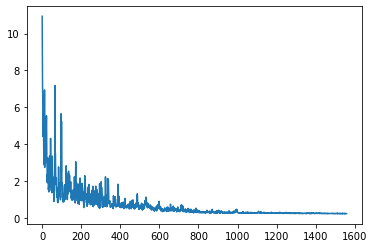

In [91]:
plt.plot(range(len(RMSE_test)), RMSE_test)

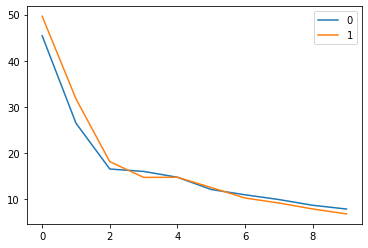

In [10]:
for key in logs.keys():
    plt.plot(range(len(logs[key])), logs[key], label=key)
    plt.legend()

In [67]:
import os
from datetime import datetime
import timeit

import torch.nn.functional as F
import torch
from torch import nn
from torch.utils.data import Dataset
from tqdm import trange
from Data import get_setup
from Inference_new import *
from Models.VI import *
from Tools import uniform_rect_sampler
import argparse


def makedirs(filename):
    if not os.path.exists(os.path.dirname(filename)):
        os.makedirs(os.path.dirname(filename))

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

date_string = datetime.now().strftime("%Y-%m-%d-%H:%M")

        
## small ##
file_name = 'Results/Paper/Exp2/Exp2_small' + date_string
log_device=device
nb_input_samples = 200
n_epochs = 50#2000
num_epochs_ensemble = 50#3000
batch_size = 50
patience=30
# predictive model architecture
layerwidth = 50
nblayers = 1
activation = nn.ReLU()
datasets = ['yacht']
SEEDS = [117 + i for i in range(2)]



In [68]:
MODELS=torch.load("Results/Paper/Exp2/Exp2_small2021-01-28-00:59_models.pt")

In [69]:
datasets = ['boston', 'concrete', 'energy','wine']
# for key in MODELS.keys():
#     datasets.append(key)

methods=[ 'MC dropout','Ensemble', 'MFVI', 'FuNN-MFVI', 'NN-HyVI', 'FuNN-HyVI']
# for key in MODELS['energy'][0][1].keys():
#     methods.append(key)
    
datasets, methods

(['boston', 'concrete', 'energy', 'wine'],
 ['MC dropout', 'Ensemble', 'MFVI', 'FuNN-MFVI', 'NN-HyVI', 'FuNN-HyVI'])

In [70]:
from Metrics import rmse, lpp, lpp_gaussian
def get_metrics(y_pred, sigma_noise, y_test, std_y_train, time, gaussian_prediction=False):
    metrics = {}
    rmse_test, _ = rmse(y_pred.mean(dim=0).cpu(), y_test.cpu(), std_y_train.cpu())
    metrics.update({'RMSE': rmse_test})

    if gaussian_prediction:
        lpp_test, _ = lpp_gaussian(y_pred.cpu(), y_test.cpu(), sigma_noise.cpu(), std_y_train.cpu())
    else:
        lpp_test, _ = lpp(y_pred.cpu(), y_test.cpu(), sigma_noise.view(1, 1, 1).cpu(), std_y_train.cpu())

    metrics.update({'LPP': lpp_test})
    metrics.update({'time [s]': time})
    metrics.update({'std noise': sigma_noise.item()})
    return metrics

In [71]:
results=[]

for dataset in datasets:   

    for split in MODELS[dataset]:
        split_results={}
        x_train, y_train=split[0]['train']
        x_test, y_test=split[0]['test']
        input_dim=x_test.shape[1]
        std_y_train=split[0]['scaler_y']

        method="Ensemble"
        model = ensemble(input_dim, layerwidth, activation, num_models=5).to(device)
        model.load_state_dict(split[1][method][0])
        y_pred=model(x_test)
        metrics = get_metrics(y_pred, torch.tensor(0.), y_test, std_y_train, split[1][method][2], gaussian_prediction=True)
        metrics.update({'dataset':dataset,'method':method})
        results.append(metrics)

        method="MC dropout"
        model = MC_Dropout(input_dim, 1, layerwidth, init_sigma_noise=1., drop_prob=0.05, learn_noise=True,
                               activation=activation).to(device)
        model.load_state_dict(split[1][method][0])
        y_pred=model.predict(x_test, 1000)
        metrics = get_metrics(y_pred, model.sigma_noise, y_test, std_y_train, split[1][method][2], gaussian_prediction=True)
        metrics.update({'dataset':dataset,'method':method})
        results.append(metrics)
            
        method="MFVI"
        model = MFVI(input_dim, layerwidth, nblayers, activation, init_sigma_noise=1., learn_noise=True, std_mu_init=1., sigma_init=0.001).to(device)
        model.load_state_dict(split[1][method][0])
        y_pred=model(x_test,1000)
        metrics = get_metrics(y_pred, model.sigma_noise, y_test, std_y_train, split[1][method][2])
        metrics.update({'dataset':dataset,'method':method})
        results.append(metrics)
        
        method="NN-HyVI"
        model = HyVI(input_dim, layerwidth, nblayers, activation, init_sigma_noise=1., learn_noise=True,lat_dim=5).to(device)
        model.load_state_dict(split[1][method][0])
        y_pred=model(x_test,1000)
        metrics = get_metrics(y_pred, model.sigma_noise, y_test, std_y_train, split[1][method][2])
        metrics.update({'dataset':dataset,'method':method})
        results.append(metrics)
        
        method="FuNN-HyVI"
        model = HyVI(input_dim, layerwidth, nblayers, activation, init_sigma_noise=1., learn_noise=True,lat_dim=5).to(device)
        model.load_state_dict(split[1][method][0])
        y_pred=model(x_test,1000)
        metrics = get_metrics(y_pred, model.sigma_noise, y_test, std_y_train, split[1][method][2])
        metrics.update({'dataset':dataset,'method':method})
        results.append(metrics)
        
        method="FuNN-MFVI"
        model = MFVI(input_dim, layerwidth, nblayers, activation, init_sigma_noise=1., learn_noise=True, std_mu_init=1., sigma_init=0.001).to(device)
        model.load_state_dict(split[1][method][0])
        y_pred=model(x_test,1000)
        metrics = get_metrics(y_pred, model.sigma_noise, y_test, std_y_train, split[1][method][2])
        metrics.update({'dataset':dataset,'method':method})
        results.append(metrics)
        
        #Results.append({dataset:split_results})

# RMSE

In [72]:
import pandas as pd

df=pd.DataFrame(results).loc[:,['dataset','method','RMSE']].groupby(['dataset','method']).mean()#.transpose()
df_sem=pd.DataFrame(results).loc[:,['dataset','method','RMSE']].groupby(['dataset','method']).sem()

def collapse_columns(df):
    df = df.copy()
    if isinstance(df.columns, pd.MultiIndex):
        df.columns = df.columns.to_series().apply(lambda x: x[1])
    return df

df_=collapse_columns(df.unstack()).reindex(columns=methods)
df_sem_=collapse_columns(df_sem.unstack()).reindex(columns=methods)
df_.style.highlight_min(axis=1)


,MC dropout,Ensemble,MFVI,FuNN-MFVI,NN-HyVI,FuNN-HyVI
dataset,,,,,,
boston,3.445005,3.393448,3.806637,4.263208,3.763577,3.733206
concrete,4.701709,4.126360,5.106430,5.644098,4.719857,4.748313
energy,0.565473,0.410518,0.462766,0.572800,0.437220,0.457115
wine,0.614606,0.578331,0.636277,0.695617,0.706899,0.668369


In [73]:
for i in df_.columns:
    df_[i] = df_[i].round(3).astype(str)+ "±" + (df_sem_[i].round(3)).astype(str)+""

In [74]:
print(df_.to_latex())

\begin{tabular}{lllllll}
\toprule
{} &   MC dropout &     Ensemble &         MFVI &    FuNN-MFVI &      NN-HyVI &    FuNN-HyVI \\
dataset  &              &              &              &              &              &              \\
\midrule
boston   &  3.445±0.342 &  3.393±0.339 &  3.807±0.248 &  4.263±0.476 &  3.764±0.476 &  3.733±0.229 \\
concrete &  4.702±0.177 &  4.126±0.227 &  5.106±0.152 &  5.644±0.235 &    4.72±0.16 &  4.748±0.266 \\
energy   &  0.565±0.023 &  0.411±0.021 &  0.463±0.022 &  0.573±0.034 &  0.437±0.039 &   0.457±0.04 \\
wine     &  0.615±0.049 &  0.578±0.021 &  0.636±0.031 &  0.696±0.017 &  0.707±0.009 &  0.668±0.049 \\
\bottomrule
\end{tabular}



# LPP

In [75]:
import pandas as pd

df=pd.DataFrame(results).loc[:,['dataset','method','LPP']].groupby(['dataset','method']).mean()#.transpose()
df_sem=pd.DataFrame(results).loc[:,['dataset','method','LPP']].groupby(['dataset','method']).sem()

def collapse_columns(df):
    df = df.copy()
    if isinstance(df.columns, pd.MultiIndex):
        df.columns = df.columns.to_series().apply(lambda x: x[1])
    return df

df_=collapse_columns(df.unstack()).reindex(columns=methods)
df_sem_=collapse_columns(df_sem.unstack()).reindex(columns=methods)
df_.style.highlight_max(axis=1)


,MC dropout,Ensemble,MFVI,FuNN-MFVI,NN-HyVI,FuNN-HyVI
dataset,,,,,,
boston,-6.783755,-4.242977,-2.838530,-7.385003,-4.475218,-13.118575
concrete,-5.371823,-6.191169,-3.084173,-3.621460,-3.260467,-3.595562
energy,-1.001856,-1.785005,-0.665002,-1.307401,-0.564611,-0.876110
wine,-13.074314,-2.361021,-0.965299,-1.262125,-1.236484,-1.396277


In [270]:
for i in df_.columns:
    df_[i] = df_[i].round(3).astype(str)+ "±" + (df_sem_[i].round(3)).astype(str)+""

In [271]:
print(df_.to_latex())

\begin{tabular}{lllllll}
\toprule
{} &    MC dropout &      Ensemble &          MFVI &     FuNN-MFVI &       NN-HyVI &      FuNN-HyVI \\
dataset  &               &               &               &               &               &                \\
\midrule
boston   &  -6.775±0.683 &  -4.243±0.304 &  -2.823±0.098 &  -7.328±2.056 &   -4.524±0.95 &  -13.107±1.172 \\
concrete &  -5.378±0.312 &  -6.191±1.566 &  -3.084±0.041 &  -3.611±0.144 &  -3.259±0.104 &   -3.596±0.218 \\
energy   &  -1.012±0.068 &  -1.561±0.303 &  -0.641±0.054 &  -1.306±0.175 &   -0.51±0.087 &   -0.955±0.316 \\
\bottomrule
\end{tabular}



# displaying logs

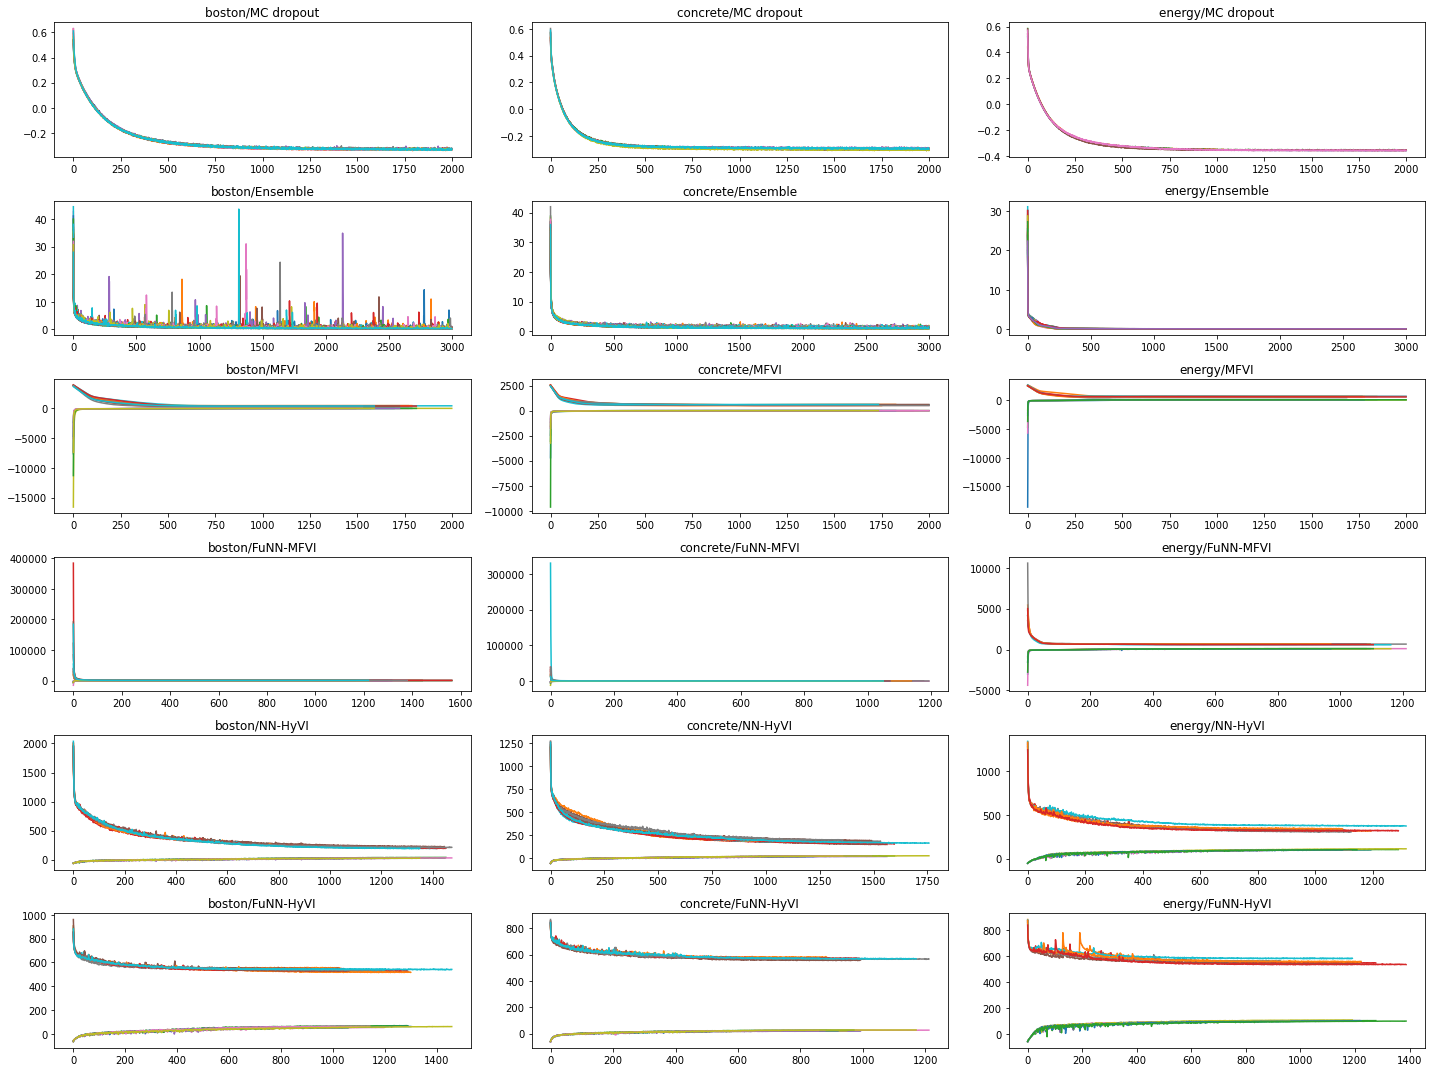

In [292]:
from pylab import *
datasets = ['boston', 'concrete', 'energy']
fig, ax=plt.subplots(len(methods), len(datasets), figsize=(20,15))
ax=ax.flatten()
i=0
for method in methods:
    for dataset in datasets:
        for split in MODELS[dataset]: 
            logs=split[1][method][1]
            for key in logs.keys():
                if key=='KL' or key=='loss' or key=='LL' or isinstance(key, int): 
                    ax[i].plot(range(len(logs[key])), logs[key])
                #ax[i].legend()
                ax[i].set_title(dataset+'/'+method)
        i+=1

fig.tight_layout()

# OOD detection

In [8]:
device='cpu'
from Tools import uniform_rect_sampler
from Metrics import batch_entropy_nne
Hs=[]
#MODELS.to(device)
def Entropy(Y):
    return [torch.cat([batch_entropy_nne(y_.transpose(0, 1), k=30) for y_ in y.split(100)]).cpu() for y in Y] 
for dataset in datasets:   

    for split in MODELS[dataset]:
        split_results={}
        x_train, y_train=split[0]['train']
        x_test, y_test=split[0]['test']
        input_dim=x_test.shape[1]
        std_y_train=split[0]['scaler_y']
        
        OOD_sampler = uniform_rect_sampler(x_train, n=10000)
        x_OOD=OOD_sampler()
        
        X = [x_train, x_test, x_OOD]

        torch.cat([model(x_, 1000) for x_ in x_OOD.split(100,dim=0)],dim=1)
#         method="Ensemble"
#         model = ensemble(input_dim, layerwidth, activation, num_models=5).to(device)
#         model.load_state_dict(split[1][method][0])
#         _Y = [model(x) for x in X]
#         Y = [y.mean(0) + y.std(0) * torch.randn(1000, y.shape[1], 1).to(device) for y in _Y]
#         H = Entropy(Y)     
#         Hs.append({'dataset':dataset,'method':method, 'H':H})

#         method="MC dropout"
#         model = MC_Dropout(input_dim, 1, layerwidth, init_sigma_noise=1., drop_prob=0.05, learn_noise=True,
#                                activation=activation).to(device)
#         model.load_state_dict(split[1][method][0])
#         _Y = [model.predict(x, 1000)[0] for x in X]
#         Y = [y.mean(0) + y.std(0) * torch.randn(1000, y.shape[1], 1).to(device) for y in _Y]
#         H = Entropy(Y)     
#         Hs.append({'dataset':dataset,'method':method, 'H':H})
            
        method="MFVI"
        model = MFVI(input_dim, layerwidth, nblayers, activation, init_sigma_noise=1., learn_noise=True, std_mu_init=1., sigma_init=0.001).to(device)
        model.load_state_dict(split[1][method][0])
#         for x in X:
#             print(x.shape)
#             for x_ in x.split(100,dim=0):
#                 print (x_.shape)
#             print(torch.cat([model(x_, 1000) for x_ in x.split(100,dim=0)],dim=1).shape)
        Y = [torch.cat([model(x_, 1000) for x_ in x.split(100,dim=0)],dim=1) for x in X]
        H = Entropy(Y)     
        Hs.append({'dataset':dataset,'method':method, 'H':H})
        
#         method="NN-HyVI"
#         model = HyVI(input_dim, layerwidth, nblayers, activation, init_sigma_noise=1., learn_noise=True,lat_dim=5).to(device)
#         model.load_state_dict(split[1][method][0])
#         Y = [model(x, 1000) for x in X]
#         H = Entropy(Y)     
#         Hs.append({'dataset':dataset,'method':method, 'H':H})

        
#         method="FuNN-HyVI"
#         model = HyVI(input_dim, layerwidth, nblayers, activation, init_sigma_noise=1., learn_noise=True,lat_dim=5).to(device)
#         model.load_state_dict(split[1][method][0])
#         Y = [model(x, 1000) for x in X]
#         H = Entropy(Y)     
#         Hs.append({'dataset':dataset,'method':method, 'H':H})
        
#         method="FuNN-MFVI"
#         model = MFVI(input_dim, layerwidth, nblayers, activation, init_sigma_noise=1., learn_noise=True, std_mu_init=1., sigma_init=0.001).to(device)
#         model.load_state_dict(split[1][method][0])
#         Y = [model(x, 1000) for x in X]
#         H = Entropy(Y)     
#         Hs.append({'dataset':dataset,'method':method, 'H':H})
        

NameError: name 'datasets' is not defined

In [7]:
cd ..

/home/yann/IVISpaces


In [30]:
import torch
from torch.distributions import MultivariateNormal

G=MultivariateNormal(torch.zeros(100), covariance_matrix=torch.randn(100,100)+20*torch.eye(100))

In [31]:
G.entropy()
G.log_prob(torch.zeros(100))

tensor(-228.6985)

In [32]:
from Metrics import entropy_nne
x=G.sample((10,))
G.log_prob(x).mean()
x.shape

torch.Size([10, 100])

In [55]:
H=[{'H':entropy_nne(G.sample((n,))).item(), 'n':n} for n in range(5,100) for _ in range(100)]

In [56]:
G.entropy()

tensor(278.6985)

ValueError: x and y must have same first dimension, but have shapes (95,) and (9500,)

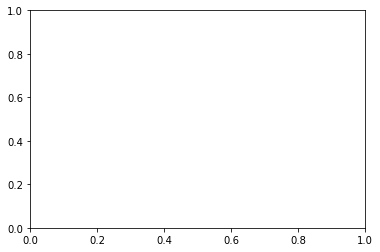

In [57]:
from pylab import *
import seaborn as sns
plt.plot(range(5,100),H)
plt.hlines(G.entropy(), 5, 100)

In [59]:
from pylab import *
import seaborn as sns
import pandas as pd

df=pd.DataFrame(H)
df

,H,n
0,322.141357,5
1,318.860840,5
2,316.987000,5
3,323.690887,5
4,316.850830,5
...,...,...
9495,311.621948,99
9496,309.300385,99
9497,309.931305,99
9498,309.482391,99


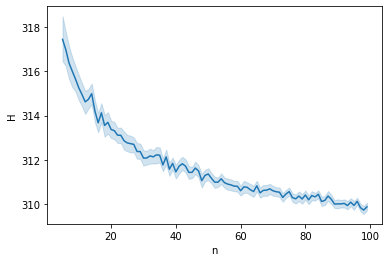

In [62]:
sns.lineplot(data=df, x="n", y="H")
#plt.hlines(G.entropy(), 5, 100)